# Initial demo with data preprocessing from proof of concept

In [1]:
# Necessary Imports
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import os
import torch.optim as optim

In [2]:
'''
# Path to 1 data set
file_path = "C:/Users/vkuma/School/Rice/DeepLearning/FinalProject/Balabit_MouseDynamicsData/training_files/user7/session_0041905381"

# Read the data from the file
with open(file_path, 'r') as f:
    lines = f.readlines()

# Skip the header and process the rest of the data
data_values = []

# Process each line
for line in lines[1:]:  # Skip the header line
    parts = line.strip().split(',')  # Split the line by commas
    x = float(parts[4])  # x-coordinate
    y = float(parts[5])  # y-coordinate
    client_timestamp = float(parts[1])  # client timestamp
    data_values.append([x, y, client_timestamp])

# Convert the list of data values into a NumPy array
data = np.array(data_values)

# Display the first 5 rows and the shape of the dataset
print(data[:5])  # Display the first 5 rows
print(data.shape)  # Display the shape of the dataset
'''


'\n# Path to 1 data set\nfile_path = "C:/Users/vkuma/School/Rice/DeepLearning/FinalProject/Balabit_MouseDynamicsData/training_files/user7/session_0041905381"\n\n# Read the data from the file\nwith open(file_path, \'r\') as f:\n    lines = f.readlines()\n\n# Skip the header and process the rest of the data\ndata_values = []\n\n# Process each line\nfor line in lines[1:]:  # Skip the header line\n    parts = line.strip().split(\',\')  # Split the line by commas\n    x = float(parts[4])  # x-coordinate\n    y = float(parts[5])  # y-coordinate\n    client_timestamp = float(parts[1])  # client timestamp\n    data_values.append([x, y, client_timestamp])\n\n# Convert the list of data values into a NumPy array\ndata = np.array(data_values)\n\n# Display the first 5 rows and the shape of the dataset\nprint(data[:5])  # Display the first 5 rows\nprint(data.shape)  # Display the shape of the dataset\n'

In [3]:
# Define the directory containing the files
directory_path = "C:/Users/vkuma/School/Rice/DeepLearning/FinalProject/Balabit_MouseDynamicsData/training_files/user7"

# Initialize a list to store all trajectories from all files
all_trajectories = []

# Iterate over all files in the directory
for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    
    # Read the data from the file
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Skip the header and process the rest of the data
    data_values = []
    state_values = []

    for line in lines[1:]:  # Skip the header line
        parts = line.strip().split(',')  # Split the line by commas
        x = float(parts[4])  # x-coordinate
        y = float(parts[5])  # y-coordinate
        client_timestamp = float(parts[1])  # client timestamp
        state = parts[3]  # State (e.g., "Move", "Pressed")
        
        data_values.append([x, y, client_timestamp])
        state_values.append(state)

    # Convert to NumPy arrays
    data = np.array(data_values)
    state_values = np.array(state_values)

    # Trajectory extraction for this file
    trajectories = []
    current_trajectory = []

    for i in range(len(data)):
        if state_values[i] == "Move":  # Only include points with state == "Move"
            current_trajectory.append(data[i])
        else:
            # If the state changes from "Move", save the current trajectory
            if current_trajectory:
                trajectories.append(np.array(current_trajectory))
                current_trajectory = []

    # Save the last trajectory if it exists
    if current_trajectory:
        trajectories.append(np.array(current_trajectory))

    # Add trajectories from this file to the global list
    all_trajectories.extend(trajectories)

    # Print summary for this file
    print(f"Processed {filename}: Extracted {len(trajectories)} trajectories.")

# Display total results across all files
print(f"Total trajectories extracted from all files: {len(all_trajectories)}")


Processed session_0041905381: Extracted 1311 trajectories.
Processed session_1060325796: Extracted 692 trajectories.
Processed session_3320405034: Extracted 1210 trajectories.
Processed session_3826583375: Extracted 911 trajectories.
Processed session_6668463071: Extracted 800 trajectories.
Processed session_8961330453: Extracted 825 trajectories.
Processed session_9017095287: Extracted 1154 trajectories.
Total trajectories extracted from all files: 6903


In [4]:
# Filter trajectories for length 50+ and trim to 50 points
filtered_trajectories = []

for traj in all_trajectories:
    if len(traj) >= 50:  # Check if the trajectory has at least 50 points
        filtered_trajectories.append(traj[:50])  # Trim to exactly 50 points

# Print the results
print(f"Number of filtered trajectories (length 50+): {len(filtered_trajectories)}")

Number of filtered trajectories (length 50+): 3111


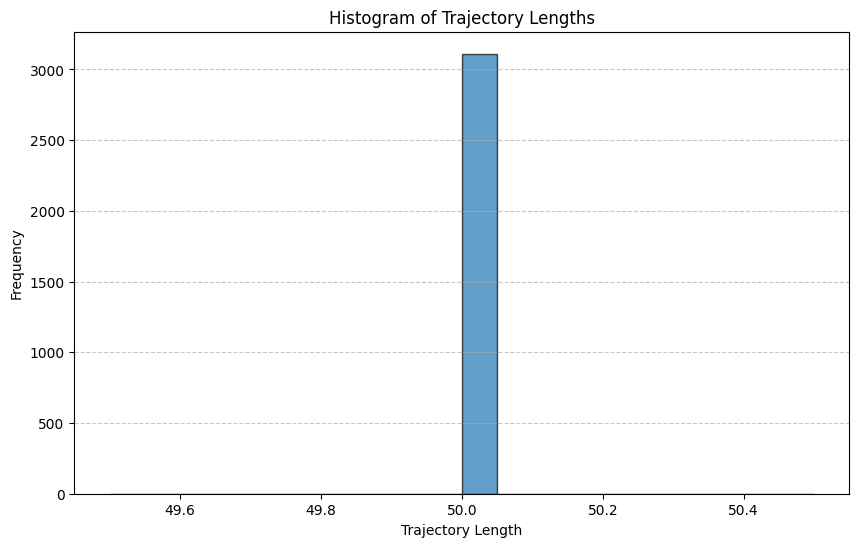

In [5]:
# Calculate the lengths of all trajectories
trajectory_lengths = [len(traj) for traj in filtered_trajectories]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(trajectory_lengths, bins=20, edgecolor='black', alpha=0.7)
plt.title("Histogram of Trajectory Lengths")
plt.xlabel("Trajectory Length")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [6]:
# Rescale each trajectory to start at (0, 0, 0)
rescaled_trajectories = []

for traj in filtered_trajectories:
    start_point = traj[0]  # Starting point (x, y, t)
    rescaled_traj = traj - start_point  # Subtract the starting point from all points
    rescaled_trajectories.append(rescaled_traj)

# Convert to a NumPy array for training
rescaled_trajectories = np.array(rescaled_trajectories)
# Calculate the maximum values for x and y
max_x = np.max([np.max(np.abs(rescaled_trajectories[i][:, 0])) for i in range(len(rescaled_trajectories))])
max_y = np.max([np.max(np.abs(rescaled_trajectories[i][:, 1])) for i in range(len(rescaled_trajectories))])

# Scale each trajectory's x and y values between [-1, 1]
for i in range(len(rescaled_trajectories)):
    # Scale the x (first column) and y (second column) of each trajectory
    rescaled_trajectories[i][:, 0] /= max_x  # Scale x by max_x
    rescaled_trajectories[i][:, 1] /= max_y  # Scale y by max_y

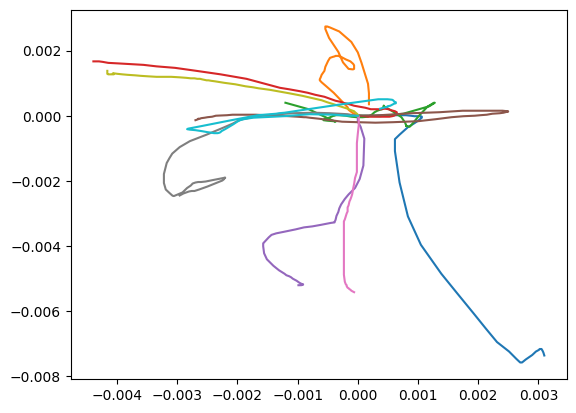

In [7]:
random_selection = np.random.randint(0,len(filtered_trajectories), 10)
for i in random_selection:
    #plt.plot(filtered_trajectories[i][:,0], filtered_trajectories[i][:,1])
    plt.plot(rescaled_trajectories[i][:,0], rescaled_trajectories[i][:,1])

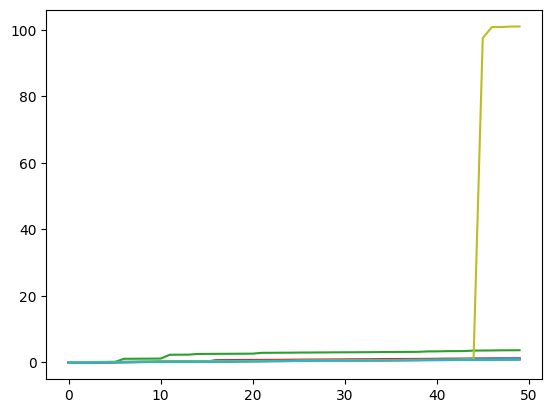

In [8]:
for i in random_selection:
    #plt.plot(filtered_trajectories[i][:,2])
    plt.plot(rescaled_trajectories[i][:,2])

In [9]:
inputs = []
outputs = []

for traj in rescaled_trajectories:
    endpoint = traj[-1, :2]  # Final point [x_end, y_end] (omit time t)
    trajectory = traj[:, :2]  # Full trajectory [x, y] (omit time t)
    inputs.append(endpoint)
    outputs.append(trajectory)

# Convert inputs and outputs to NumPy arrays
inputs = np.array(inputs)
outputs = np.array(outputs)
print(f"Inputs shape: {np.shape(inputs)}")
print(f"Outputs shape: {np.shape(outputs)}")

Inputs shape: (3111, 2)
Outputs shape: (3111, 50, 2)


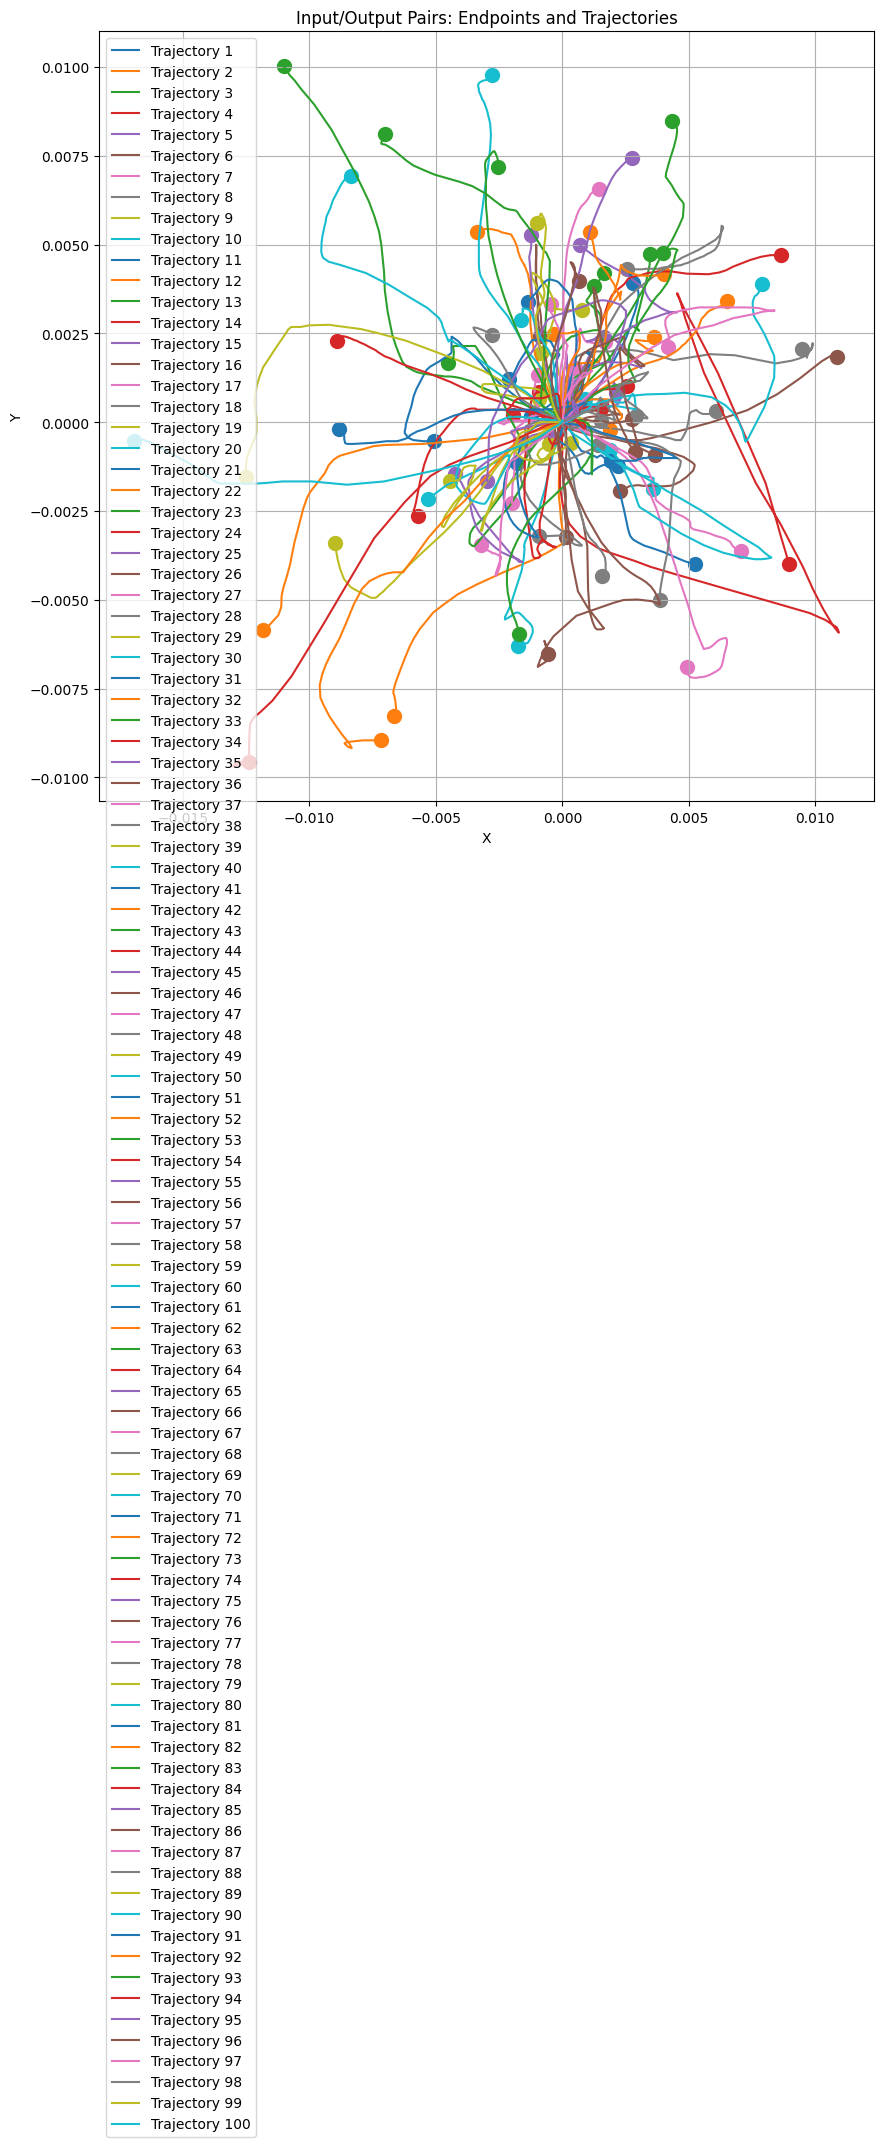

In [10]:
num_samples = 100
indices = np.random.choice(len(inputs), num_samples, replace=False)

# Create a plot
plt.figure(figsize=(10, 10))

for idx, i in enumerate(indices):
    endpoint = inputs[i]  # Endpoint of the trajectory
    trajectory = outputs[i]  # Full trajectory

    # Plot the trajectory
    plt.plot(trajectory[:, 0], trajectory[:, 1], label=f'Trajectory {idx+1}')
    # Plot the endpoint
    plt.scatter(endpoint[0], endpoint[1], marker='o', s=100)  # Match color with trajectory

plt.title("Input/Output Pairs: Endpoints and Trajectories")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.legend()
plt.show()

In [11]:
class TrajectoryDataset(Dataset):
    def __init__(self, inputs, outputs):
        """
        Custom Dataset for trajectory data.
        :param inputs: NumPy array of shape (n_trajectories, 2) - Endpoints [x_end, y_end]
        :param outputs: NumPy array of shape (n_trajectories, n_points, 2) - Trajectories [x, y]
        """
        self.inputs = torch.tensor(inputs, dtype=torch.float32)
        self.outputs = torch.tensor(outputs, dtype=torch.float32)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        """
        Return a single input-output pair at the specified index.
        """
        input_data = self.inputs[idx]
        output_data = self.outputs[idx]
        return input_data, output_data


# Create Dataset and DataLoader
trajectory_dataset = TrajectoryDataset(inputs, outputs)

# Define a DataLoader for batch processing
batch_size = 32
data_loader = DataLoader(trajectory_dataset, batch_size=batch_size, shuffle=True)

# Example: Iterating through the DataLoader
for batch_idx, (endpoints, trajectories) in enumerate(data_loader):
    print(f"Batch {batch_idx+1}")
    print("Endpoints:", endpoints.shape)  # Shape: (batch_size, 2)
    print("Trajectories:", trajectories.shape)  # Shape: (batch_size, n_points, 2)
    break  # Process one batch as an example

Batch 1
Endpoints: torch.Size([32, 2])
Trajectories: torch.Size([32, 50, 2])


In [12]:
class TrajectoryMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, trajectory_len):
        super(TrajectoryMLP, self).__init__()
        self.trajectory_len = trajectory_len  # Number of coordinate pairs in the trajectory

        # Define the MLP
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, trajectory_len * output_dim)  # Output full trajectory
        )

    def forward(self, x):
        # Pass the input through the MLP
        out = self.mlp(x)  # Shape: (batch_size, trajectory_len * output_dim)

        # Reshape to get trajectory points
        out = out.view(-1, self.trajectory_len, output_dim)  # Shape: (batch_size, trajectory_len, output_dim)

        return out

# Hyperparameters
input_dim = 2  # Endpoint [x_end, y_end]
hidden_dim = 128  # Number of hidden units
output_dim = 2  # Trajectory points (x, y)
trajectory_len = 50  # Number of coordinate pairs
batch_size = 32
learning_rate = 0.001
epochs = 50

# Initialize the model
model = TrajectoryMLP(input_dim, hidden_dim, output_dim, trajectory_len)

In [13]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate*0.01)

# Training loop with penalty term
penalty_weight = 1e5  # Weight for the penalty term

# Lists to store losses
total_losses = []
trajectory_losses = []
penalty_losses = []

for epoch in range(epochs):
    epoch_total_loss = 0.0
    epoch_trajectory_loss = 0.0
    epoch_penalty_loss = 0.0

    for batch_idx, (endpoints, trajectories) in enumerate(data_loader):
        # Zero the gradient
        optimizer.zero_grad()

        # Forward pass
        outputs = model(endpoints)  # Shape: (batch_size, trajectory_len, output_dim)

        # Compute the primary trajectory loss (MSE)
        loss_trajectory = criterion(outputs, trajectories)

        # Compute the penalty term
        predicted_endpoints = outputs[:, -1, :]  # The last point in the predicted trajectory
        loss_penalty = torch.mean(torch.sum((predicted_endpoints - endpoints) ** 2, dim=1))  # MSE for endpoint

        # Total loss
        total_loss = loss_trajectory + penalty_weight * loss_penalty

        # Backward pass and optimization
        total_loss.backward()
        optimizer.step()

        # Accumulate losses for this batch
        epoch_total_loss += total_loss.item()
        epoch_trajectory_loss += loss_trajectory.item()
        epoch_penalty_loss += penalty_weight * loss_penalty.item()

    # Average losses for the epoch
    epoch_total_loss /= len(data_loader)
    epoch_trajectory_loss /= len(data_loader)
    epoch_penalty_loss /= len(data_loader)

    # Store epoch losses
    total_losses.append(epoch_total_loss)
    trajectory_losses.append(epoch_trajectory_loss)
    penalty_losses.append(epoch_penalty_loss)

    print(f"Epoch {epoch+1}/{epochs}, Total Loss: {epoch_total_loss}, "
          f"Trajectory Loss: {epoch_trajectory_loss}, Penalty Loss: {epoch_penalty_loss}")

Epoch 1/50, Total Loss: 2383.6579440369896, Trajectory Loss: 0.008604534820900584, Penalty Loss: 2383.6493321067214
Epoch 2/50, Total Loss: 826.4393061423789, Trajectory Loss: 0.007011996715196541, Penalty Loss: 826.4322945734068
Epoch 3/50, Total Loss: 230.10229499972596, Trajectory Loss: 0.0058335358590571856, Penalty Loss: 230.09645947426253
Epoch 4/50, Total Loss: 51.66575638128786, Trajectory Loss: 0.004875343502023999, Penalty Loss: 51.66088109146994
Epoch 5/50, Total Loss: 10.753113118969665, Trajectory Loss: 0.004065661769531363, Penalty Loss: 10.749047493047737
Epoch 6/50, Total Loss: 4.026853768192992, Trajectory Loss: 0.003381913962621926, Penalty Loss: 4.023471833812548
Epoch 7/50, Total Loss: 3.217601472017716, Trajectory Loss: 0.0028092418631006566, Penalty Loss: 3.21479221606658
Epoch 8/50, Total Loss: 3.1571499437701944, Trajectory Loss: 0.002331332750238326, Penalty Loss: 3.154818594859015
Epoch 9/50, Total Loss: 3.1254174441707376, Trajectory Loss: 0.00193181554121630

In [14]:
'''
class TrajectoryModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(TrajectoryModel, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Assume x has shape (batch_size, seq_len, input_dim)
        out, _ = self.rnn(x)
        out = self.fc(out)  # Shape: (batch_size, seq_len, output_dim)
        return out

# Define model, loss, and optimizer
input_dim = 2  # Endpoint [x_end, y_end]
hidden_dim = 64
output_dim = 2  # Trajectory points [x, y]
num_layers = 2

model = TrajectoryModel(input_dim, hidden_dim, output_dim, num_layers)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)
'''

'\nclass TrajectoryModel(torch.nn.Module):\n    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):\n        super(TrajectoryModel, self).__init__()\n        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)\n        self.fc = torch.nn.Linear(hidden_dim, output_dim)\n\n    def forward(self, x):\n        # Assume x has shape (batch_size, seq_len, input_dim)\n        out, _ = self.rnn(x)\n        out = self.fc(out)  # Shape: (batch_size, seq_len, output_dim)\n        return out\n\n# Define model, loss, and optimizer\ninput_dim = 2  # Endpoint [x_end, y_end]\nhidden_dim = 64\noutput_dim = 2  # Trajectory points [x, y]\nnum_layers = 2\n\nmodel = TrajectoryModel(input_dim, hidden_dim, output_dim, num_layers)\ncriterion = torch.nn.MSELoss()\noptimizer = torch.optim.Adam(model.parameters(), lr=0.000001)\n'

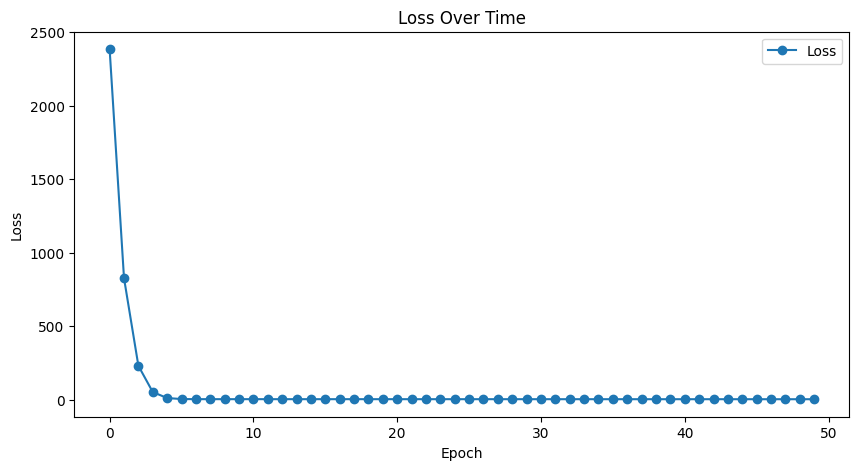

In [15]:
# Plot epoch losses
plt.figure(figsize=(10, 5))
plt.plot(total_losses, label="Loss", marker='o')
plt.title("Loss Over Time")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [16]:
# Example endpoint input
endpoint = torch.tensor([[0.5, -0.8]])

# Ensure the model is in evaluation mode
model.eval()

# Generate trajectory
with torch.no_grad():
    # Add sequence dimension (e.g., [batch_size, seq_len, input_dim])
    endpoint_input = endpoint.unsqueeze(1)  # Shape: (batch_size, seq_len=1, input_dim)
    generated_trajectory = model(endpoint_input)  # Output: (batch_size, seq_len, output_dim)

# Convert to NumPy for easy visualization or further processing
generated_trajectory = generated_trajectory.squeeze(0).numpy()  # Remove batch dimension
print("Generated Trajectory:", generated_trajectory)

Generated Trajectory: [[-1.09312065e-01  6.37754798e-02]
 [-7.38200620e-02 -3.86585295e-02]
 [-1.57137997e-02  1.35133378e-02]
 [-3.30104679e-02 -7.43586943e-02]
 [-4.13339511e-02  6.58194274e-02]
 [-2.03774720e-02  3.27263679e-03]
 [-4.64309677e-02  1.84348430e-02]
 [-1.50766596e-02 -4.39576730e-02]
 [ 6.68375194e-02 -1.72882918e-02]
 [-3.66934687e-02 -2.99417395e-02]
 [ 5.46403527e-02 -4.03115563e-02]
 [ 5.34286834e-02 -5.85681200e-03]
 [-3.86635065e-02  9.48047042e-02]
 [-1.02595240e-02 -7.48608559e-02]
 [-3.53365056e-02 -2.22712681e-02]
 [ 3.08784284e-02  1.08185560e-01]
 [-2.62953453e-02 -1.47667006e-02]
 [ 5.19961491e-02 -4.28117514e-02]
 [-1.77173745e-02  1.10512897e-02]
 [ 1.38445988e-01  3.55192572e-02]
 [-5.71654923e-02 -2.07301211e-02]
 [ 5.95003366e-04  2.23768093e-02]
 [ 7.65727311e-02 -2.39987671e-03]
 [ 2.15625875e-02  5.09161763e-02]
 [-6.49396330e-03 -1.98208522e-02]
 [-4.78645936e-02 -1.51271746e-03]
 [-2.48139873e-02 -5.94113395e-02]
 [ 2.13979930e-02  4.12413366e-02

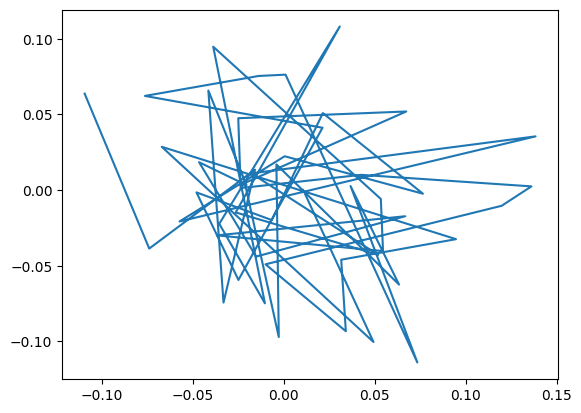

In [17]:
plt.plot(generated_trajectory[:,0], generated_trajectory[:,1])